In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from wlkbacktest import Strategy
from talib.abstract import BBANDS

In [2]:
# BOLL
def BOLL(data, timeperiod=25, nbdevup=2, nbdevdn=2, matype=0):
    df = data.join(BBANDS(data, timeperiod, nbdevup, nbdevdn, matype))
    buy = (df.close.shift(1) < df.upperband.shift(1)) & (df.close > df.upperband)
    sell = (df.close.shift(1) > df.lowerband.shift(1)) & (df.close < df.lowerband)
    df['signal'] = np.where(buy, 1, np.where(sell, -1, np.nan))
    df.signal = df.signal.shift(1)
    return df

In [3]:
dfs = pd.read_csv('D:/Data/Minute/1/zz500.csv',index_col=0,parse_dates=True)

In [4]:
def max_dn(pl):
    return np.max(1 - pl / pd.expanding_max(pl))
def max_up(pl):
    return np.max(pl / pd.expanding_min(pl) - 1)

In [5]:
max_up_ts = pd.rolling_apply(dfs.close,window=720,func=max_up)
max_dd_ts = pd.rolling_apply(dfs.close,window=720,func=max_dn)

In [6]:
DF = BOLL(dfs,timeperiod=5000,nbdevup=2.2, nbdevdn=2.2)

In [7]:
STK = 'zz500'
# 初始化策略变量
def init(context,**kwargs):
    context.start = '20130101'
    context.end = '20151231'
    context.cash = 10000000
    context.minute = 1
    context._slippage = 0.2  # 交易滑点
    context.commision = 0.02 #万二
    context.securities = [STK]

    context.long_short = None # 持仓方向
    context.holding_times = 0
    context.cost = None #记录开仓成本价

    
# 策略交易逻辑
def algo(data,broker,context,**kwargs):
    stk = STK
    now = broker.now # 获取当前回测日期(日期或每天分钟)
    signal = DF.at[now,'signal']
    ex_price = DF.at[now,'open']
    
    # 空仓 非最后一个交易日
    if context.holding_times==0 and now < context.end:
        if signal == 1:
            broker.order_percent(stk,ex_price,1,'long')
            context.cost = ex_price
            print(now,stk,'long open')
            context.long_short = 'long'
            context.holding_times = 1
        elif signal == -1:
            broker.order_percent(stk,ex_price,1,'short')
            context.cost = ex_price
            context.long_short = 'short'
            context.holding_times = 1
            print(now,stk,'short open')
    # 持有
    elif context.holding_times!=0:
        if now >= context.end:
            broker.order_percent(stk,ex_price,-1,context.long_short)
            #print(now,stk,'last day out')
            context.long_short = None
            context.holding_times = 0
            return
        else:
 
            # 价格止损和最近N天走势止损
            price = DF.at[now,'close']
            if context.long_short =='long':
                if (price/context.cost < 0.96):
                    broker.order_percent(stk,price,-1,'long')
                    print('long stop loss 1:',now)
                    context.holding_times = 0
                    context.long_short = None
                    context.cost = None
                    return
            elif context.long_short =='short':
                if (context.cost/price < 0.96):
                    broker.order_percent(stk,price,-1,'short')
                    print('short stop loss 1:',now)
                    context.holding_times = 0
                    context.long_short = None
                    context.cost = None
                    return
            
            if context.long_short =='long' and signal==-1:
                broker.order_percent(stk,ex_price,-1,'long')
                context.long_short = None
                context.holding_times = 0
                print(now,stk,'long exit')
                return
            elif context.long_short =='short' and signal==1:
                broker.order_percent(stk,ex_price,-1,'short')
                context.long_short = None
                context.holding_times = 0
                print(now,stk,'short exit')
                return
            
            if context.holding_times > 720:
                if context.long_short=='long':
                    max_dd = max_dd_ts.at[now]
                    if max_dd > 0.04:
                        broker.order_percent(stk,price,-1,'long')
                        print('long stop loss 2:',now)
                        context.holding_times = 0
                        context.long_short = None
                        context.cost = None
                        return
                elif context.long_short=='short':
                    max_up = max_up_ts.at[now]
                    if max_up > 0.04:
                        broker.order_percent(stk,price,-1,'short')
                        print('short stop loss 2:',now)
                        context.holding_times = 0
                        context.long_short = None
                        context.cost = None
                        return
        context.holding_times += 1

In [8]:
strategy = Strategy(init)
strategy.run_backtest(algo)
df = strategy.backtest_analysis()

2013-02-08 10:44:00 zz500 long open
long stop loss 2: 2013-03-04 14:40:00
2013-03-12 13:02:00 zz500 short open
short stop loss 2: 2013-03-20 14:04:00
2013-04-08 09:32:00 zz500 short open
short stop loss 2: 2013-04-11 09:33:00
2013-04-16 09:32:00 zz500 short open
short stop loss 1: 2013-04-19 09:46:00
2013-05-07 10:38:00 zz500 long open
long stop loss 2: 2013-06-04 13:29:00
2013-06-13 09:49:00 zz500 short open
short stop loss 2: 2013-06-18 09:50:00
2013-06-20 14:51:00 zz500 short open
short stop loss 2: 2013-06-25 14:52:00
2013-06-26 10:16:00 zz500 short open
short stop loss 2: 2013-07-01 10:17:00
2013-08-12 09:53:00 zz500 long open
long stop loss 2: 2013-08-16 14:51:00
2013-09-04 09:38:00 zz500 long open
long stop loss 2: 2013-10-23 11:18:00
2013-10-29 10:55:00 zz500 short open
short stop loss 2: 2013-11-01 10:56:00
2013-12-20 10:26:00 zz500 short open
short stop loss 2: 2014-01-16 13:40:00
2014-01-27 13:44:00 zz500 long open
long stop loss 2: 2014-02-24 09:44:00
2014-03-10 14:15:00 zz

In [9]:
df

,value
Performance Statistics,
起始日,2013-01-04
结束日,2015-12-31
初始资金,10000000
结束资金,21335414.5642
总盈亏,11335414.5642
累计收益,1.1335
年化收益,0.2888
年化波动率,0.1744
交易时长,2 年 11 月 27 日


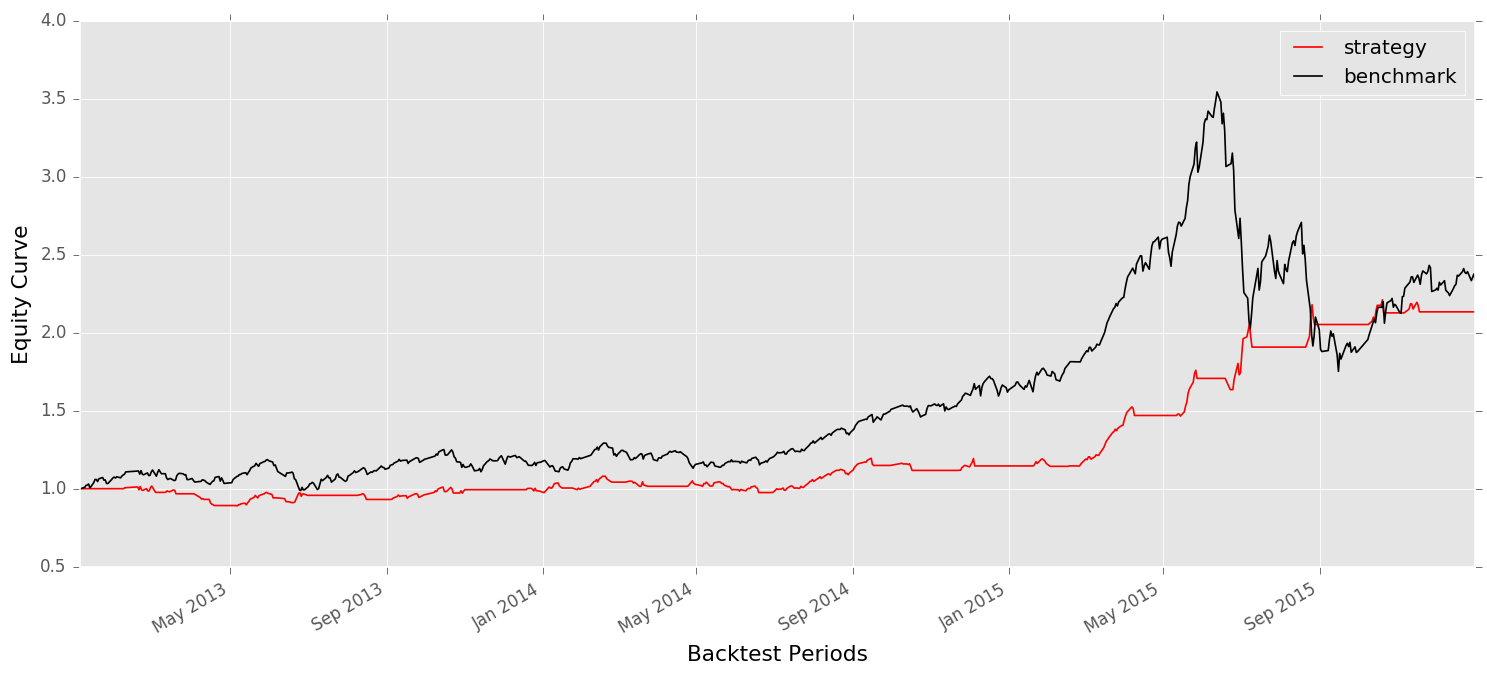

In [10]:
strategy.show_equity_curve()

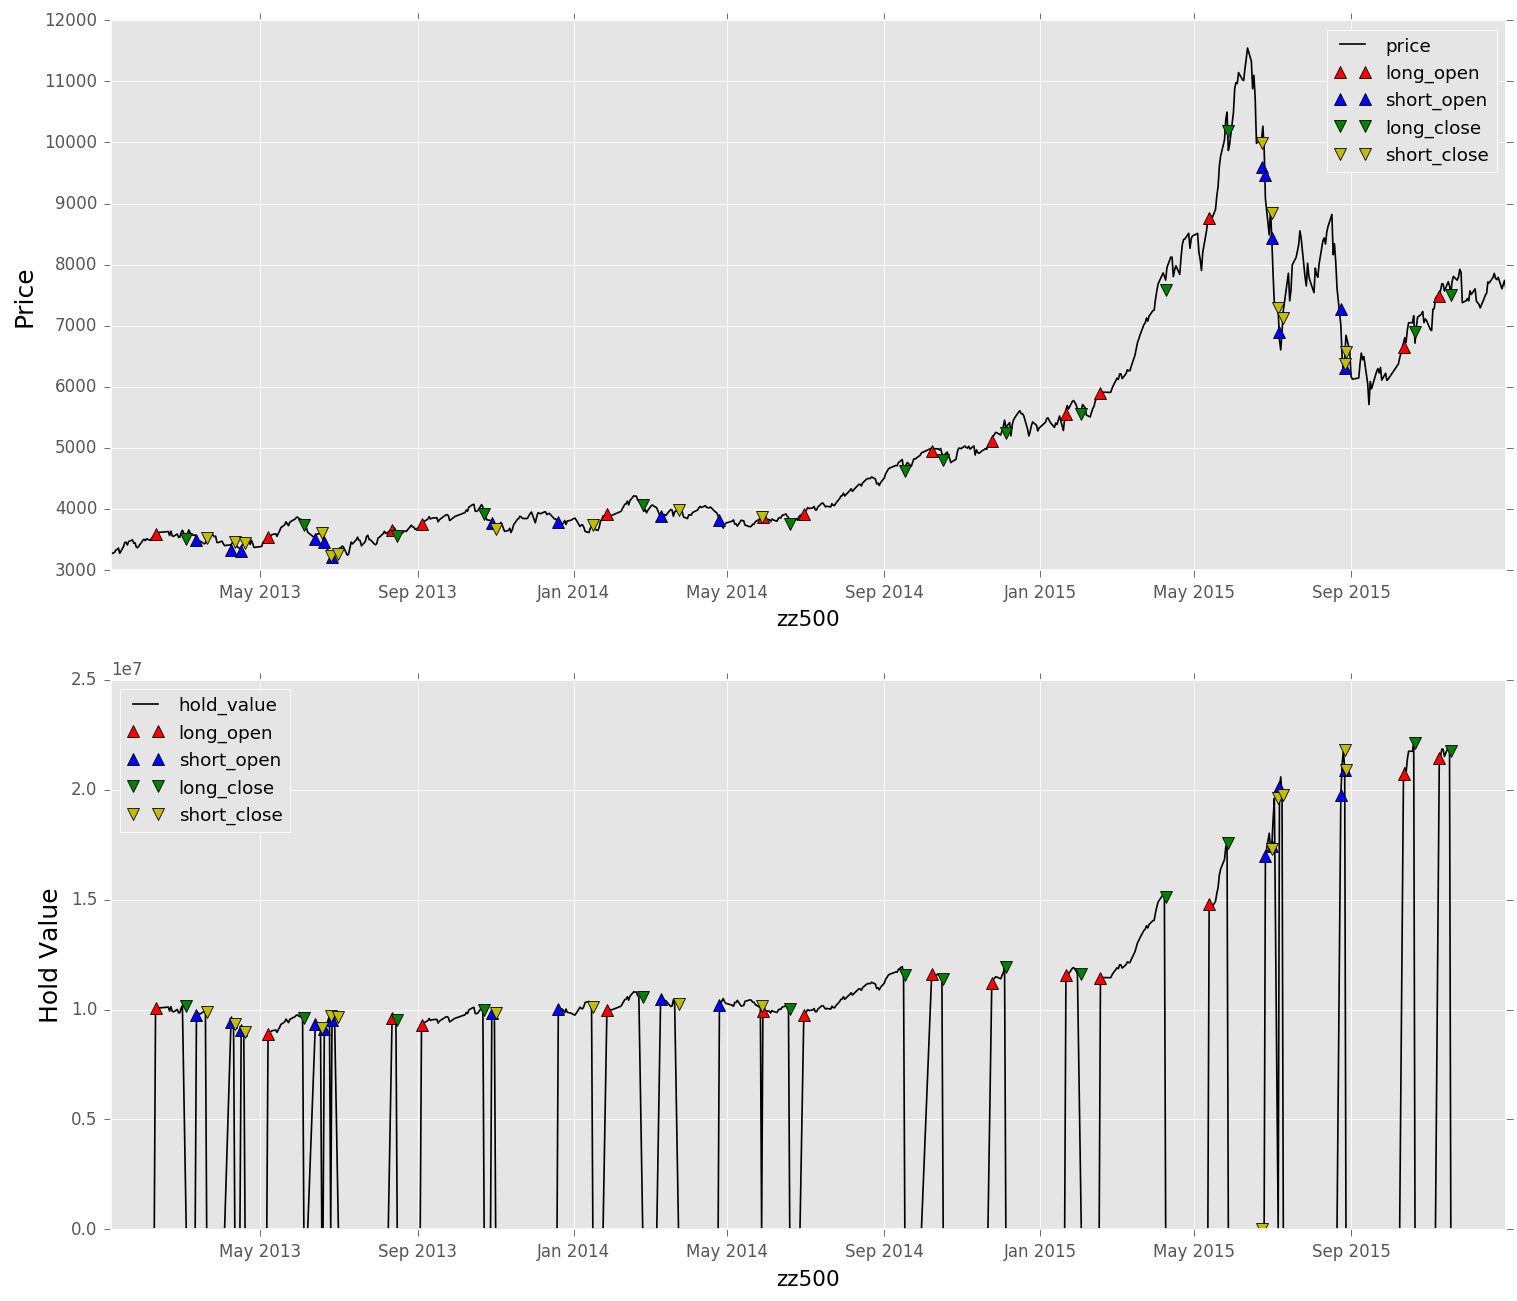

In [11]:
strategy.show_trade_information()